<a href="https://colab.research.google.com/github/PeterG2001/Portfolio/blob/main/Deep_Learning_Image_Classification_with_the_EMNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - Multilayer Perceptron

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## *1. Indicate the imported packages/libraries*

In [ ]:
# for generral Pytorch functionality
import torch
# for nerual network based functions
import torch.nn as nn
import torch.nn.functional as F
#  for our optimizer which whill update the parameters of our nerual network
import torch.optim as optim
# for handling our dataset
import torch.utils.data as data
# for data augmentation
import torchvision.transforms as transforms
# for loading the adataset
import torchvision.datasets as datasets
import torch.optim.lr_scheduler as lr_scheduler
# for visualising a confusion matrix
from sklearn import metrics
# for visualising  a the neural networks representations in two dimensions 
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
# for plotting
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

from os.path import exists
from google.colab import files
from tqdm import trange
from torch.autograd import Variable


import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


# Hyperparameters 

In [ ]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=15  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).
args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=False # If the Cuda flag is set to True then the model is moved to the GPU using the GPU() method

Ensuring that we get reproducible results

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#  - Data Preprocessing

## *2. Load the dataset (you can import PyTorch dataset library to download the dataset)*

Loading the dataset 

In [ ]:
ROOT = '.data'

train_data = datasets.EMNIST(root=ROOT,
                            split='balanced',
                            train=True,
                            download=True)

100%|██████████| 561753746/561753746 [00:12<00:00, 44536845.91it/s]


Extracting .data/EMNIST/raw/gzip.zip to .data/EMNIST/raw


Normalising the data

We want to have a mean of zero and a standard deviation of one
Normalising our data allows our models to train fasters and also helps them avoid local minima i.e train more reliably
Note: It is important that the mean and standard deviation are only calculated over the training set and not the test set
The image data has values between 0-255, which we want to scale between 0-1 so we divide by 255

In [ ]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

In [ ]:
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.17510418593883514
Calculated std: 0.3332371413707733


Transforming the data


A transfrom states how our data should be augmented and processed
Data augmentation involves manipulating the available training data in a way that artificially creates more training examples
We use transforms.Compose to build a list of transformationsthat will be applied to the image

In [ ]:
train_transforms = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

## *3. Split data into a training dataset and a testing dataset (e.g., using DataLoader in PyTorch)*

Loading the data with the relevant transformations 

In [ ]:
train_data = datasets.EMNIST(root=ROOT,
                            split='balanced',
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.EMNIST(root=ROOT,
                           split='balanced',
                           train=False,
                           download=True,
                           transform=test_transforms)

## *4. Understand the dataset and visualize the dataset*

###  *i. Print out the number of training/testing samples in the dataset.*

Checking the legnth of the datasets to see how many examples are within each 

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 112800
Number of testing examples: 18800


Looking at some of the images within our dataset
The function below plots a square grid of images

### *ii. Plot some figures to visualize some samples in the dataset (we will provide the mapping .txt file for “Balanced” dataset, if you can implement mapping from the index to the classes by yourself, you can ignore the .txt file).*

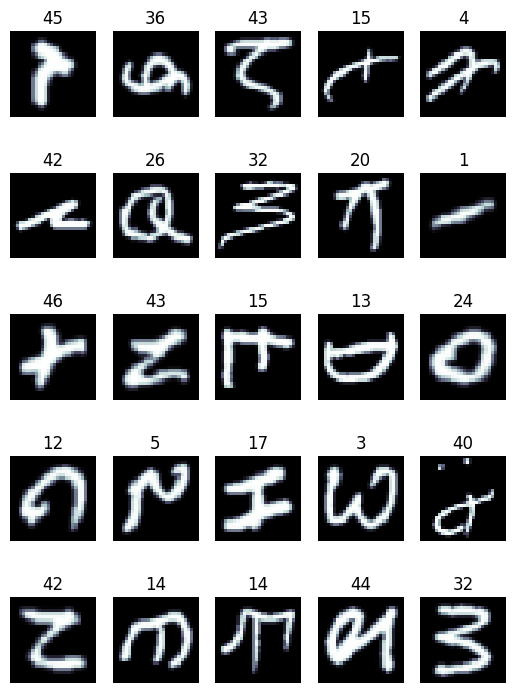

In [ ]:
def plot_images(images,label):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure()
    plt.subplots_adjust(top=1.5,hspace=0.4)
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols,i+1)
        ax.imshow(images[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(torch.tensor(label[i]).item())
        ax.axis('off')

N_IMAGES = 25

images, label = zip(*[train_data[i] for i in range(N_IMAGES)])

plot_images(images,label)

Loading 25 images which have been processed through our transforms

Cross Validation/Validation Set

In [ ]:
VALID_RATIO = 0.7

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples


In [ ]:
train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])



In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 78960
Number of validation examples: 33840
Number of testing examples: 18800


## Here we change the validation forms transform by overwrirting it with our test transforms

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

##Defining a DataLoader for each of the training/test/validation set. We can iterate over these

In [ ]:
BATCH_SIZE = 1000 # Use the batch argument in the Hyperparameter block to define the batch size


train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Defining the MLP

* Here we have a the mlp with three hidden layers 
* We define our model by creating an instance of it and setting the correct input and output dimensions

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, activation, use_batch_norm=False, use_dropout=False):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 400)
        self.hidden_fc1 = nn.Linear(400, 250)
        self.hidden_fc2 = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

        self.activation = activation
        self.activation_fn = {
            'leakyrelu':nn.LeakyReLU(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
        }[activation]

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        if use_batch_norm:
            self.batch_norm_input = nn.BatchNorm1d(400)
            self.batch_norm_fc1 = nn.BatchNorm1d(250)
            self.batch_norm_fc2 = nn.BatchNorm1d(100)

        if use_dropout:
            self.dropout = nn.Dropout(p=0.2)


    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]
        if self.use_batch_norm:
          ip_1=self.batch_norm_input(self.input_fc(x))
        else:
          ip_1=self.input_fc(x)

        # ip_1=self.input_fc(x)
        h_1 = self.activation_fn(ip_1)
        if self.use_dropout:
          h_1=self.dropout(h_1)

        # h_1 = [batch size, 400]
        if self.use_batch_norm:
          ip_2=self.batch_norm_fc1(self.hidden_fc1(h_1))
        else:
          ip_2=self.hidden_fc1(h_1)

        # ip_2=self.hidden_fc1(h_1)
        h_2 = self.activation_fn(ip_2)
        if self.use_dropout:
          h_2=self.dropout(h_2)

        # h_2 = [batch size, 250]
        if self.use_batch_norm:
          ip_3=self.batch_norm_fc2(self.hidden_fc2(h_2))
        else:
          ip_3=self.hidden_fc2(h_2)

        # ip_3=self.hidden_fc2(h_2)
        h_3 = self.activation_fn(ip_3)
        if self.use_dropout:
          h_3=self.dropout(h_3)

        # h_3 = [batch size, 100]

        y_pred = self.output_fc(h_3)

        # y_pred = [batch size, output dim]

        return y_pred, h_3



We also create a small function to calculate the the number of trainable parameters (weigths and biases) in our model

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

Training the Model

We define our optimizer. Thisa is the algorithm we will use to update the parameters of our model with resepect to the loss calculated on the data

Defining the training loop 

This will: 
- Put our model into train mode 
- iterate over our dataset returning batches of (image, label)
- place the batch on to our GPU if we have on
- clear the gradients calculated from the last batch
- pass out batch of images x through to model to get predictions, y_pred 
- calculate the loss between our predictions and the actual labels
- calculate the accuracy between our predictions and actual labels
- calculate the gradietns of each parameter 
- update the paramers by taking an optimizer step
- update our metrics 

The model has 445,597 trainable parameters


  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 52s
	Train Loss: 2.587 | Train Acc: 29.41%
	 Val. Loss: 1.274 |  Val. Acc: 60.99%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 53s
	Train Loss: 1.517 | Train Acc: 53.56%
	 Val. Loss: 0.791 |  Val. Acc: 74.54%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 50s
	Train Loss: 1.260 | Train Acc: 60.74%
	 Val. Loss: 0.674 |  Val. Acc: 77.72%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 1.129 | Train Acc: 64.20%
	 Val. Loss: 0.610 |  Val. Acc: 80.01%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 51s
	Train Loss: 1.044 | Train Acc: 66.48%
	 Val. Loss: 0.571 |  Val. Acc: 80.71%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 50s
	Train Loss: 0.985 | Train Acc: 68.27%
	 Val. Loss: 0.543 |  Val. Acc: 81.79%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 50s
	Train Loss: 0.948 | Train Acc: 69.34%
	 Val. Loss: 0.517 |  Val. Acc: 82.43%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 50s
	Train Loss: 0.909 | Train Acc: 70.55%
	 Val. Loss: 0.504 |  Val. Acc: 82.89%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 53s
	Train Loss: 0.882 | Train Acc: 71.44%
	 Val. Loss: 0.488 |  Val. Acc: 83.24%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 51s
	Train Loss: 0.857 | Train Acc: 71.91%
	 Val. Loss: 0.479 |  Val. Acc: 83.69%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 50s
	Train Loss: 0.836 | Train Acc: 72.64%
	 Val. Loss: 0.474 |  Val. Acc: 83.45%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 50s
	Train Loss: 0.822 | Train Acc: 73.08%
	 Val. Loss: 0.464 |  Val. Acc: 83.91%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 50s
	Train Loss: 0.810 | Train Acc: 73.55%
	 Val. Loss: 0.454 |  Val. Acc: 84.27%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 51s
	Train Loss: 0.790 | Train Acc: 74.13%
	 Val. Loss: 0.450 |  Val. Acc: 84.23%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 51s
	Train Loss: 0.776 | Train Acc: 74.36%
	 Val. Loss: 0.443 |  Val. Acc: 84.60%
Training with relu activation function...


  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 51s
	Train Loss: 0.757 | Train Acc: 74.97%
	 Val. Loss: 0.440 |  Val. Acc: 84.26%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 50s
	Train Loss: 0.756 | Train Acc: 74.94%
	 Val. Loss: 0.435 |  Val. Acc: 84.83%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 50s
	Train Loss: 0.748 | Train Acc: 75.26%
	 Val. Loss: 0.434 |  Val. Acc: 84.72%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 0.739 | Train Acc: 75.52%
	 Val. Loss: 0.420 |  Val. Acc: 85.19%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 50s
	Train Loss: 0.735 | Train Acc: 75.70%
	 Val. Loss: 0.422 |  Val. Acc: 85.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s
	Train Loss: 0.723 | Train Acc: 76.02%
	 Val. Loss: 0.423 |  Val. Acc: 85.20%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 51s
	Train Loss: 0.716 | Train Acc: 76.19%
	 Val. Loss: 0.413 |  Val. Acc: 85.50%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 50s
	Train Loss: 0.708 | Train Acc: 76.43%
	 Val. Loss: 0.415 |  Val. Acc: 85.33%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 51s
	Train Loss: 0.707 | Train Acc: 76.49%
	 Val. Loss: 0.417 |  Val. Acc: 85.23%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 51s
	Train Loss: 0.705 | Train Acc: 76.68%
	 Val. Loss: 0.415 |  Val. Acc: 85.08%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 51s
	Train Loss: 0.699 | Train Acc: 76.78%
	 Val. Loss: 0.406 |  Val. Acc: 85.52%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 50s
	Train Loss: 0.693 | Train Acc: 77.03%
	 Val. Loss: 0.405 |  Val. Acc: 85.63%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 51s
	Train Loss: 0.692 | Train Acc: 76.96%
	 Val. Loss: 0.400 |  Val. Acc: 85.90%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 51s
	Train Loss: 0.684 | Train Acc: 77.13%
	 Val. Loss: 0.407 |  Val. Acc: 85.18%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 51s
	Train Loss: 0.680 | Train Acc: 77.36%
	 Val. Loss: 0.401 |  Val. Acc: 85.97%
Training with sigmoid activation function...


  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 51s
	Train Loss: 3.093 | Train Acc: 17.03%
	 Val. Loss: 1.994 |  Val. Acc: 53.24%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 51s
	Train Loss: 2.801 | Train Acc: 22.91%
	 Val. Loss: 1.780 |  Val. Acc: 58.25%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 53s
	Train Loss: 2.589 | Train Acc: 27.78%
	 Val. Loss: 1.544 |  Val. Acc: 63.96%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 2.382 | Train Acc: 32.60%
	 Val. Loss: 1.346 |  Val. Acc: 67.25%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 51s
	Train Loss: 2.184 | Train Acc: 37.30%
	 Val. Loss: 1.192 |  Val. Acc: 69.77%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 51s
	Train Loss: 2.018 | Train Acc: 41.29%
	 Val. Loss: 1.068 |  Val. Acc: 71.74%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 51s
	Train Loss: 1.865 | Train Acc: 44.98%
	 Val. Loss: 0.962 |  Val. Acc: 74.14%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 51s
	Train Loss: 1.754 | Train Acc: 48.01%
	 Val. Loss: 0.894 |  Val. Acc: 75.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 51s
	Train Loss: 1.656 | Train Acc: 50.57%
	 Val. Loss: 0.839 |  Val. Acc: 76.00%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 52s
	Train Loss: 1.579 | Train Acc: 52.43%
	 Val. Loss: 0.796 |  Val. Acc: 76.37%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 51s
	Train Loss: 1.515 | Train Acc: 54.23%
	 Val. Loss: 0.756 |  Val. Acc: 77.75%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 51s
	Train Loss: 1.454 | Train Acc: 55.90%
	 Val. Loss: 0.721 |  Val. Acc: 78.51%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 51s
	Train Loss: 1.407 | Train Acc: 57.20%
	 Val. Loss: 0.700 |  Val. Acc: 78.55%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 51s
	Train Loss: 1.359 | Train Acc: 58.59%
	 Val. Loss: 0.673 |  Val. Acc: 79.20%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 51s
	Train Loss: 1.313 | Train Acc: 59.60%
	 Val. Loss: 0.658 |  Val. Acc: 79.58%
Training with tanh activation function...


  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 52s
	Train Loss: 1.652 | Train Acc: 51.89%
	 Val. Loss: 0.666 |  Val. Acc: 79.16%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 52s
	Train Loss: 1.251 | Train Acc: 61.77%
	 Val. Loss: 0.610 |  Val. Acc: 80.40%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 52s
	Train Loss: 1.158 | Train Acc: 64.16%
	 Val. Loss: 0.573 |  Val. Acc: 81.27%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 52s
	Train Loss: 1.101 | Train Acc: 65.39%
	 Val. Loss: 0.552 |  Val. Acc: 81.85%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 52s
	Train Loss: 1.054 | Train Acc: 66.86%
	 Val. Loss: 0.536 |  Val. Acc: 82.31%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s
	Train Loss: 1.026 | Train Acc: 67.47%
	 Val. Loss: 0.525 |  Val. Acc: 82.40%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 1.000 | Train Acc: 68.26%
	 Val. Loss: 0.518 |  Val. Acc: 82.65%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 51s
	Train Loss: 0.975 | Train Acc: 68.98%
	 Val. Loss: 0.508 |  Val. Acc: 83.00%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 51s
	Train Loss: 0.960 | Train Acc: 69.57%
	 Val. Loss: 0.497 |  Val. Acc: 83.39%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 51s
	Train Loss: 0.946 | Train Acc: 69.85%
	 Val. Loss: 0.498 |  Val. Acc: 83.14%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 52s
	Train Loss: 0.926 | Train Acc: 70.40%
	 Val. Loss: 0.484 |  Val. Acc: 83.74%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 52s
	Train Loss: 0.913 | Train Acc: 70.73%
	 Val. Loss: 0.482 |  Val. Acc: 83.58%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 52s
	Train Loss: 0.906 | Train Acc: 70.84%
	 Val. Loss: 0.483 |  Val. Acc: 83.41%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 52s
	Train Loss: 0.894 | Train Acc: 71.31%
	 Val. Loss: 0.476 |  Val. Acc: 83.72%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 51s
	Train Loss: 0.884 | Train Acc: 71.70%
	 Val. Loss: 0.473 |  Val. Acc: 83.67%
Best activation function is None with accuracy 85.97%
Training with optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 51s
	Train Loss: 0.754 | Train Acc: 75.09%
	 Val. Loss: 0.437 |  Val. Acc: 85.07%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 51s
	Train Loss: 0.744 | Train Acc: 75.45%
	 Val. Loss: 0.429 |  Val. Acc: 84.99%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 52s
	Train Loss: 0.734 | Train Acc: 75.82%
	 Val. Loss: 0.423 |  Val. Acc: 85.14%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 52s
	Train Loss: 0.724 | Train Acc: 75.97%
	 Val. Loss: 0.421 |  Val. Acc: 85.28%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 51s
	Train Loss: 0.722 | Train Acc: 76.19%
	 Val. Loss: 0.417 |  Val. Acc: 85.36%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s
	Train Loss: 0.716 | Train Acc: 76.24%
	 Val. Loss: 0.417 |  Val. Acc: 85.49%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 0.704 | Train Acc: 76.49%
	 Val. Loss: 0.411 |  Val. Acc: 85.53%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 52s
	Train Loss: 0.693 | Train Acc: 77.00%
	 Val. Loss: 0.410 |  Val. Acc: 85.59%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 51s
	Train Loss: 0.690 | Train Acc: 76.98%
	 Val. Loss: 0.409 |  Val. Acc: 85.73%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 52s
	Train Loss: 0.689 | Train Acc: 77.14%
	 Val. Loss: 0.405 |  Val. Acc: 85.78%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 52s
	Train Loss: 0.682 | Train Acc: 77.27%
	 Val. Loss: 0.398 |  Val. Acc: 85.95%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 52s
	Train Loss: 0.677 | Train Acc: 77.52%
	 Val. Loss: 0.401 |  Val. Acc: 85.84%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 52s
	Train Loss: 0.675 | Train Acc: 77.46%
	 Val. Loss: 0.400 |  Val. Acc: 86.00%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 51s
	Train Loss: 0.671 | Train Acc: 77.77%
	 Val. Loss: 0.397 |  Val. Acc: 86.04%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 52s
	Train Loss: 0.661 | Train Acc: 77.78%
	 Val. Loss: 0.397 |  Val. Acc: 86.04%
Training with optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)


  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 52s
	Train Loss: 2.038 | Train Acc: 43.39%
	 Val. Loss: 0.831 |  Val. Acc: 72.29%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 51s
	Train Loss: 1.200 | Train Acc: 61.75%
	 Val. Loss: 0.666 |  Val. Acc: 77.27%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 51s
	Train Loss: 1.054 | Train Acc: 66.10%
	 Val. Loss: 0.581 |  Val. Acc: 79.44%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 52s
	Train Loss: 0.972 | Train Acc: 68.55%
	 Val. Loss: 0.563 |  Val. Acc: 80.55%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 52s
	Train Loss: 0.925 | Train Acc: 69.84%
	 Val. Loss: 0.529 |  Val. Acc: 81.53%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s
	Train Loss: 0.885 | Train Acc: 71.06%
	 Val. Loss: 0.514 |  Val. Acc: 82.06%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 0.864 | Train Acc: 71.96%
	 Val. Loss: 0.501 |  Val. Acc: 82.63%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 52s
	Train Loss: 0.839 | Train Acc: 72.41%
	 Val. Loss: 0.484 |  Val. Acc: 83.05%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 52s
	Train Loss: 0.815 | Train Acc: 73.19%
	 Val. Loss: 0.478 |  Val. Acc: 83.09%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 52s
	Train Loss: 0.795 | Train Acc: 73.77%
	 Val. Loss: 0.476 |  Val. Acc: 83.26%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 52s
	Train Loss: 0.790 | Train Acc: 74.04%
	 Val. Loss: 0.468 |  Val. Acc: 83.61%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 52s
	Train Loss: 0.773 | Train Acc: 74.51%
	 Val. Loss: 0.467 |  Val. Acc: 83.62%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 52s
	Train Loss: 0.769 | Train Acc: 74.57%
	 Val. Loss: 0.455 |  Val. Acc: 84.10%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 52s
	Train Loss: 0.755 | Train Acc: 75.12%
	 Val. Loss: 0.448 |  Val. Acc: 84.22%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 52s
	Train Loss: 0.749 | Train Acc: 75.18%
	 Val. Loss: 0.444 |  Val. Acc: 84.13%
Training with optimizer: Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.002
    maximize: False
    weight_decay: 0
)


  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 52s
	Train Loss: 0.703 | Train Acc: 76.50%
	 Val. Loss: 0.417 |  Val. Acc: 85.38%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 52s
	Train Loss: 0.682 | Train Acc: 77.24%
	 Val. Loss: 0.412 |  Val. Acc: 85.47%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 53s
	Train Loss: 0.676 | Train Acc: 77.52%
	 Val. Loss: 0.409 |  Val. Acc: 85.66%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 52s
	Train Loss: 0.671 | Train Acc: 77.65%
	 Val. Loss: 0.407 |  Val. Acc: 85.69%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 52s
	Train Loss: 0.666 | Train Acc: 77.67%
	 Val. Loss: 0.405 |  Val. Acc: 85.76%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s
	Train Loss: 0.658 | Train Acc: 78.05%
	 Val. Loss: 0.404 |  Val. Acc: 85.74%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 0.661 | Train Acc: 77.84%
	 Val. Loss: 0.402 |  Val. Acc: 85.85%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 52s
	Train Loss: 0.658 | Train Acc: 78.07%
	 Val. Loss: 0.401 |  Val. Acc: 85.89%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 53s
	Train Loss: 0.654 | Train Acc: 78.11%
	 Val. Loss: 0.400 |  Val. Acc: 85.96%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 52s
	Train Loss: 0.648 | Train Acc: 78.15%
	 Val. Loss: 0.398 |  Val. Acc: 85.88%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 52s
	Train Loss: 0.647 | Train Acc: 78.21%
	 Val. Loss: 0.397 |  Val. Acc: 85.99%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 52s
	Train Loss: 0.644 | Train Acc: 78.47%
	 Val. Loss: 0.396 |  Val. Acc: 86.02%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 52s
	Train Loss: 0.651 | Train Acc: 78.31%
	 Val. Loss: 0.396 |  Val. Acc: 86.04%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 52s
	Train Loss: 0.643 | Train Acc: 78.50%
	 Val. Loss: 0.394 |  Val. Acc: 86.08%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 53s
	Train Loss: 0.640 | Train Acc: 78.53%
	 Val. Loss: 0.394 |  Val. Acc: 86.10%
The optimizer with the best accuracy on the validation set is ADAM.
{'state': {0: {'step': tensor(1185.), 'exp_avg': tensor([[ 2.7591e-08,  9.4239e-08, -1.1893e-06,  ...,  3.1743e-06,
          2.2401e-06,  1.5574e-07],
        [ 1.0152e-06, -2.5754e-07,  1.3541e-07,  ...,  1.2300e-06,
          3.6844e-07,  2.5728e-07],
        [ 1.4748e-06,  4.2478e-06,  2.8233e-06,  ...,  3.7577e-08,
         -9.4681e-09, -4.7803e-08],
        ...,
        [-5.6968e-08, -1.3104e-07, -1.4953e-07,  ...,  9.8435e-07,
          3.9051e-07,  2.6584e-07],
        [ 6.4038e-07,  1.7622e-06,  2.8020e-06,  ..., -9.4220e-06,
         -7.2035e-06, -4.3100e-06],
        [ 9.3635e-07,  7.5372e-06,  9.3897e-06,  ...,  3.6200e-07,
         -3.1511e-07, -7.3033e-07]]), 'exp_inf': tensor([[5.3294e-05, 4.6604e-05, 8.3010e-05,  ..., 9.2252e-05, 7.7457e-05,
         5.6797e-05],
        [7.4482e-05, 1.0869e-04, 

  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 52s
	Train Loss: 0.642 | Train Acc: 78.48%
	 Val. Loss: 0.393 |  Val. Acc: 86.10%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 52s
	Train Loss: 0.642 | Train Acc: 78.41%
	 Val. Loss: 0.393 |  Val. Acc: 86.11%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 52s
	Train Loss: 0.639 | Train Acc: 78.60%
	 Val. Loss: 0.393 |  Val. Acc: 86.07%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 52s
	Train Loss: 0.639 | Train Acc: 78.65%
	 Val. Loss: 0.393 |  Val. Acc: 86.14%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 52s
	Train Loss: 0.637 | Train Acc: 78.59%
	 Val. Loss: 0.393 |  Val. Acc: 86.14%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 53s
	Train Loss: 0.642 | Train Acc: 78.49%
	 Val. Loss: 0.393 |  Val. Acc: 86.15%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 0.638 | Train Acc: 78.63%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 52s
	Train Loss: 0.637 | Train Acc: 78.73%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 52s
	Train Loss: 0.641 | Train Acc: 78.70%
	 Val. Loss: 0.393 |  Val. Acc: 86.11%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 52s
	Train Loss: 0.640 | Train Acc: 78.58%
	 Val. Loss: 0.394 |  Val. Acc: 86.07%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 53s
	Train Loss: 0.638 | Train Acc: 78.65%
	 Val. Loss: 0.394 |  Val. Acc: 86.10%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 53s
	Train Loss: 0.638 | Train Acc: 78.73%
	 Val. Loss: 0.393 |  Val. Acc: 86.07%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 52s
	Train Loss: 0.640 | Train Acc: 78.55%
	 Val. Loss: 0.393 |  Val. Acc: 86.14%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 52s
	Train Loss: 0.637 | Train Acc: 78.59%
	 Val. Loss: 0.394 |  Val. Acc: 86.10%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 52s
	Train Loss: 0.638 | Train Acc: 78.55%
	 Val. Loss: 0.393 |  Val. Acc: 86.07%


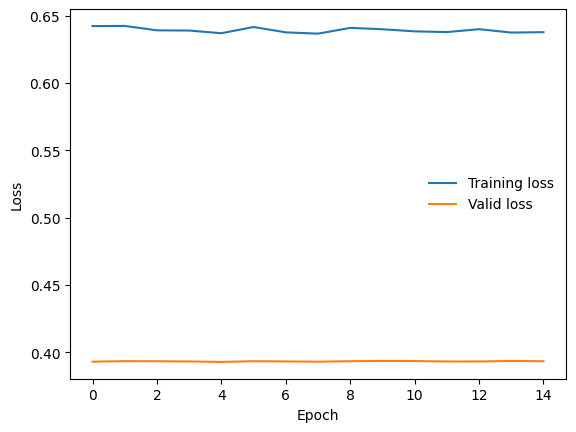

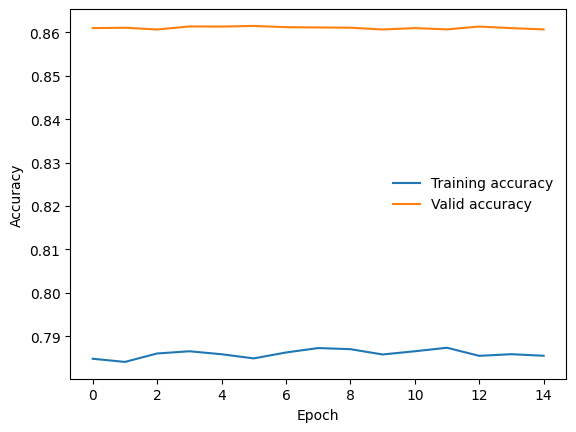

In [ ]:
def train(model, iterator, optimizer, criterion, device, l1_lambda=None, l2_lambda=None):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        if l1_lambda is not None:
            # add L1 regularization to the loss function
            l1_reg = torch.tensor(0., requires_grad=True).to(device)
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    l1_reg += torch.norm(param, 1)
            loss += l1_lambda * l1_reg

        if l2_lambda is not None:
            # add L2 regularization to the loss function
            l2_reg = torch.tensor(0., requires_grad=True).to(device)
            for name, param in model.named_parameters():
                if 'bias' not in name:
                    l2_reg += torch.norm(param, 2)
            loss += l2_lambda * l2_reg

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

INPUT_DIM = 28 * 28
OUTPUT_DIM = 47
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = criterion.to(device)

EPOCHS = 15
# train and evaluate for base model
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
best_accuracy = 0.0
model = MLP(INPUT_DIM, OUTPUT_DIM, activation='leakyrelu', use_batch_norm=True, use_dropout=True)
print(f'The model has {count_parameters(model):,} trainable parameters')
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
model = model.to(device)
for epoch in trange(EPOCHS):
  start_time = time.monotonic()

  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  if valid_acc > best_accuracy:
    best_accuracy = valid_acc
    torch.save({'model_state_dict':model.state_dict(),'best_accuracy':best_accuracy},'tut30-model.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  valid_losses.append(valid_loss)
  valid_accuracies.append(valid_acc)

# train and evaluate with different activation function
EPOCHS = 15
activations = ['relu', 'sigmoid', 'tanh']

for activation in activations:
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    best_activation = None
    print(f'Training with {activation} activation function...')
    model1= MLP(INPUT_DIM, OUTPUT_DIM, activation= activation, use_batch_norm=True, use_dropout=True)
    checkpoint=torch.load('tut30-model.pt')
    model1.load_state_dict(checkpoint['model_state_dict'])
    best_accuracy= checkpoint['best_accuracy']
    optimizer = optim.SGD(model1.parameters(), lr=0.1, momentum=0.9)
    model1 = model1.to(device)
    for epoch in trange(EPOCHS):
      start_time = time.monotonic()

      train_loss, train_acc = train(model1, train_iterator, optimizer, criterion, device)
      valid_loss, valid_acc = evaluate(model1, valid_iterator, criterion, device)

      if valid_acc > best_accuracy:
        best_accuracy = valid_acc
        best_activation = activation
        torch.save({'model_state_dict':model1.state_dict(),'best_accuracy':best_accuracy},'tut30-model.pt')

      end_time = time.monotonic()

      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

      train_losses.append(train_loss)
      train_accuracies.append(train_acc)
      valid_losses.append(valid_loss)
      valid_accuracies.append(valid_acc)

valid_accuracies = [valid_accuracies[i:i+EPOCHS] for i in range(0, len(valid_accuracies), EPOCHS)]
best_activation_idx = np.argmax([np.max(va) for va in valid_accuracies])
best_activation = ['RelU', 'Sigmoid', 'tanh'][best_activation_idx]
print(f'The optimizer with the best accuracy on the validation set is {best_activation}.')

# define the optimizers
EPOCHS = 15
if best_activation is None:
    best_activation = 'relu'
model2= MLP(INPUT_DIM, OUTPUT_DIM, activation= best_activation, use_batch_norm=True, use_dropout=True)
checkpoint=torch.load('tut30-model.pt')
model2.load_state_dict(checkpoint['model_state_dict'])
best_accuracy= checkpoint['best_accuracy']
optimizer_Adam = optim.Adam(model2.parameters())
optimizer_RMSProp = optim.RMSprop(model2.parameters())
optimizer_ADAMAX = optim.Adamax(model2.parameters())

for optimizer in [optimizer_Adam, optimizer_RMSProp, optimizer_ADAMAX]:
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    print(f'Training with optimizer: {optimizer}')
    best_valid_loss = float('inf')

    for epoch in trange(EPOCHS):

        start_time = time.monotonic()

        train_loss, train_acc = train(model2, train_iterator, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model2, valid_iterator, criterion, device)

        if valid_acc > best_accuracy:
          best_accuracy = valid_acc
          torch.save({'model_state_dict':model2.state_dict(),
                      'optimizer_state_dict': optimizer.state_dict(),
                      'best_accuracy':best_accuracy},'tut30-model.pt')

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

# determine the optimizer with the best accuracy
valid_accuracies = [valid_accuracies[i:i+EPOCHS] for i in range(0, len(valid_accuracies), EPOCHS)]
best_optimizer_idx = np.argmax([np.max(va) for va in valid_accuracies])
best_optimizer = ['ADAM', 'RMSPROP', 'ADAMAX'][best_optimizer_idx]
print(f'The optimizer with the best accuracy on the validation set is {best_optimizer}.')

#using adaptive learing rates

EPOCHS = 15

checkpoint=torch.load('tut30-model.pt')
best_accuracy= checkpoint['best_accuracy']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
optimizer_state_dict = optimizer.state_dict()
model3 = MLP(INPUT_DIM, OUTPUT_DIM, activation= best_activation, use_batch_norm=True, use_dropout=True)
model3.load_state_dict(checkpoint['model_state_dict'])
model3 = model3.to(device)

best_valid_loss = float('inf')

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []


# Define the learning rate scheduler for StepLR
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Define the learning rate scheduler for CosineAnnealingLR
cos_annealing_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.01)

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model3, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model3, valid_iterator, criterion, device)

    if valid_acc > best_accuracy:
      best_accuracy = valid_acc
      torch.save({'model_state_dict':model3.state_dict(),'optimizer_state_dict': optimizer.state_dict(),
                  'best_accuracy':best_accuracy},'tut30-model.pt')


    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    step_lr_scheduler.step()
    cos_annealing_lr_scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

# plot the loss graph
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot the accuracy graph
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Valid accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 55s
	Train Loss: 13061.287 | Train Acc: 78.71%
	 Val. Loss: 0.393 |  Val. Acc: 86.06%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 51s
	Train Loss: 13061.287 | Train Acc: 78.56%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 51s
	Train Loss: 13061.288 | Train Acc: 78.51%
	 Val. Loss: 0.394 |  Val. Acc: 86.04%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 13061.286 | Train Acc: 78.64%
	 Val. Loss: 0.393 |  Val. Acc: 86.14%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 52s
	Train Loss: 13061.288 | Train Acc: 78.61%
	 Val. Loss: 0.394 |  Val. Acc: 86.06%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 51s
	Train Loss: 13061.285 | Train Acc: 78.75%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 13061.289 | Train Acc: 78.69%
	 Val. Loss: 0.394 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 52s
	Train Loss: 13061.286 | Train Acc: 78.70%
	 Val. Loss: 0.394 |  Val. Acc: 86.07%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 51s
	Train Loss: 13061.286 | Train Acc: 78.55%
	 Val. Loss: 0.393 |  Val. Acc: 86.11%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 51s
	Train Loss: 13061.289 | Train Acc: 78.62%
	 Val. Loss: 0.393 |  Val. Acc: 86.10%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 52s
	Train Loss: 13061.284 | Train Acc: 78.69%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 51s
	Train Loss: 13061.288 | Train Acc: 78.76%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 52s
	Train Loss: 13061.287 | Train Acc: 78.44%
	 Val. Loss: 0.394 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 52s
	Train Loss: 13061.285 | Train Acc: 78.64%
	 Val. Loss: 0.394 |  Val. Acc: 86.08%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 52s
	Train Loss: 13061.289 | Train Acc: 78.60%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


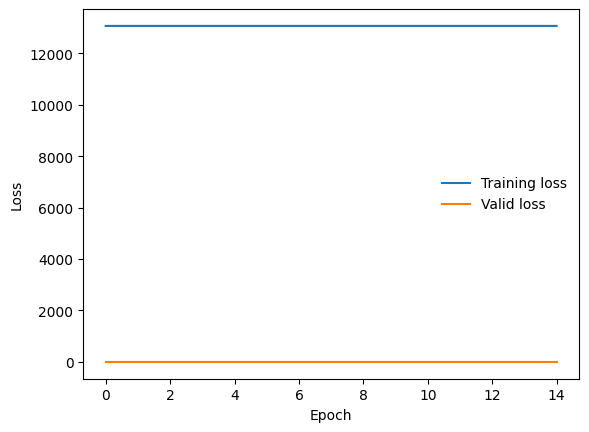

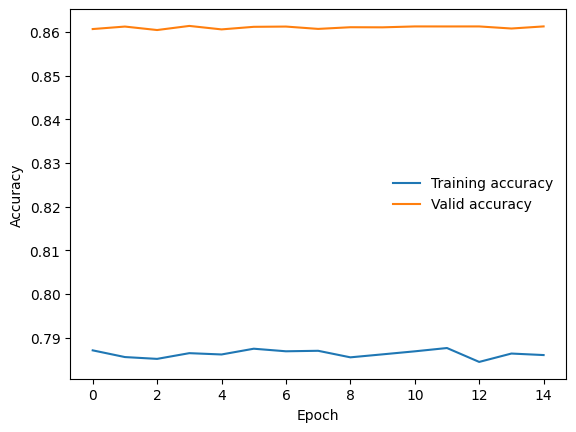

  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 52s
	Train Loss: 50.946 | Train Acc: 78.50%
	 Val. Loss: 0.393 |  Val. Acc: 86.18%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 51s
	Train Loss: 50.946 | Train Acc: 78.51%
	 Val. Loss: 0.393 |  Val. Acc: 86.08%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 51s
	Train Loss: 50.945 | Train Acc: 78.70%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 50.947 | Train Acc: 78.63%
	 Val. Loss: 0.394 |  Val. Acc: 86.07%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 52s
	Train Loss: 50.940 | Train Acc: 78.76%
	 Val. Loss: 0.393 |  Val. Acc: 86.09%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s
	Train Loss: 50.941 | Train Acc: 78.77%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 50.946 | Train Acc: 78.48%
	 Val. Loss: 0.393 |  Val. Acc: 86.07%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 52s
	Train Loss: 50.948 | Train Acc: 78.68%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 52s
	Train Loss: 50.945 | Train Acc: 78.50%
	 Val. Loss: 0.394 |  Val. Acc: 86.03%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 52s
	Train Loss: 50.947 | Train Acc: 78.57%
	 Val. Loss: 0.393 |  Val. Acc: 86.08%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 52s
	Train Loss: 50.947 | Train Acc: 78.60%
	 Val. Loss: 0.393 |  Val. Acc: 86.11%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 52s
	Train Loss: 50.943 | Train Acc: 78.75%
	 Val. Loss: 0.393 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 52s
	Train Loss: 50.946 | Train Acc: 78.59%
	 Val. Loss: 0.393 |  Val. Acc: 86.07%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 54s
	Train Loss: 50.945 | Train Acc: 78.57%
	 Val. Loss: 0.394 |  Val. Acc: 86.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 52s
	Train Loss: 50.944 | Train Acc: 78.48%
	 Val. Loss: 0.393 |  Val. Acc: 86.07%


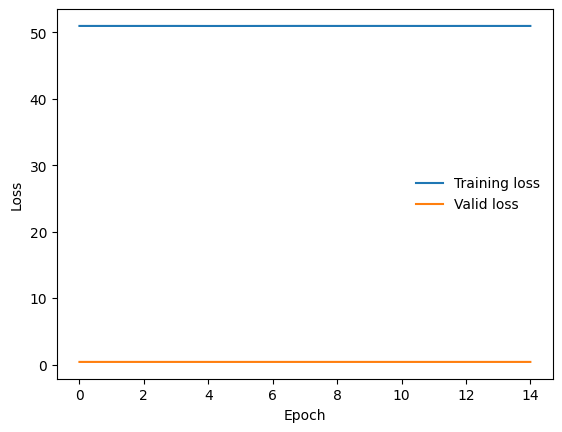

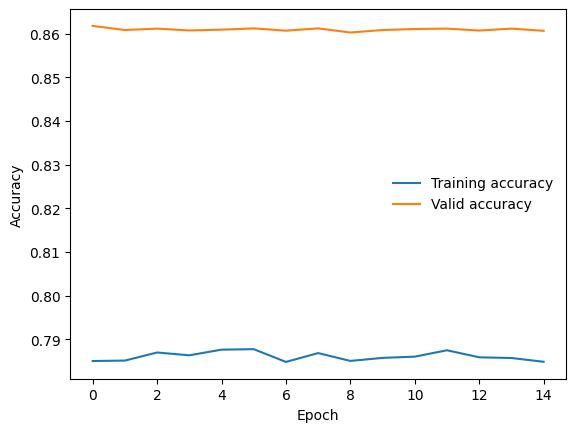

In [ ]:
def train(model, iterator, optimizer, criterion, device, l1_lambda=None, l2_lambda=None):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        if l1_lambda is not None:
            # add L1 regularization to the loss function
            l1_loss = torch.tensor(0., requires_grad=True)
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l1_loss = l1_loss + torch.norm(param, 1)    
            loss = loss + l1_lambda * l1_loss
        if l2_lambda is not None:
            # add L2 regularization to the loss function
            l2_loss = torch.tensor(0., requires_grad=True)
            for name, param in model.named_parameters():
                if 'weight' in name:
                    l2_loss = l2_loss + torch.norm(param, 2)
            loss = loss + l2_lambda * l2_loss

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)
EPOCHS = 15

model4 = MLP(INPUT_DIM, OUTPUT_DIM, activation= best_activation, use_batch_norm=True, use_dropout=True)
checkpoint=torch.load('tut30-model.pt')
best_accuracy= checkpoint['best_accuracy']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model4.load_state_dict(checkpoint['model_state_dict'])
model4 = model4.to(device)

best_valid_loss = float('inf')

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model4, train_iterator, optimizer, criterion, device, l1_lambda=0.1, l2_lambda=None)
    valid_loss, valid_acc = evaluate(model4, valid_iterator, criterion, device)

    if valid_acc > best_accuracy:
      best_accuracy = valid_acc
      torch.save(model4.state_dict(),'tut31-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

# plot the loss graph
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot the accuracy graph
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Valid accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

EPOCHS = 15

checkpoint=torch.load('tut30-model.pt')
best_accuracy= checkpoint['best_accuracy']
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model5 = MLP(INPUT_DIM, OUTPUT_DIM, activation= best_activation, use_batch_norm=True, use_dropout=True)
model5.load_state_dict(checkpoint['model_state_dict'])
model5 = model5.to(device)

best_valid_loss = float('inf')

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model5, train_iterator, optimizer, criterion, device, l1_lambda=None, l2_lambda=0.1)
    valid_loss, valid_acc = evaluate(model5, valid_iterator, criterion, device)

    if valid_acc > best_accuracy:
      best_accuracy = valid_acc
      torch.save(model5.state_dict(), 'tut31-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

# plot the loss graph
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot the accuracy graph
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Valid accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 53s
	Train Loss: 3.944 | Train Acc: 2.03%
	 Val. Loss: 3.947 |  Val. Acc: 1.51%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 51s
	Train Loss: 3.946 | Train Acc: 2.00%
	 Val. Loss: 3.947 |  Val. Acc: 1.51%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 52s
	Train Loss: 3.944 | Train Acc: 2.03%
	 Val. Loss: 3.947 |  Val. Acc: 1.49%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 3.944 | Train Acc: 2.02%
	 Val. Loss: 3.946 |  Val. Acc: 1.51%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 51s
	Train Loss: 3.945 | Train Acc: 1.96%
	 Val. Loss: 3.947 |  Val. Acc: 1.49%


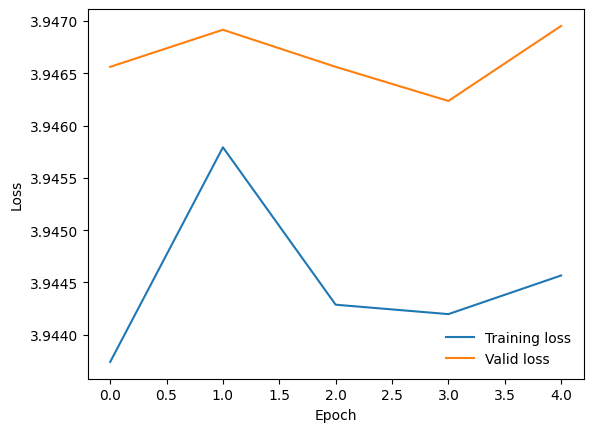

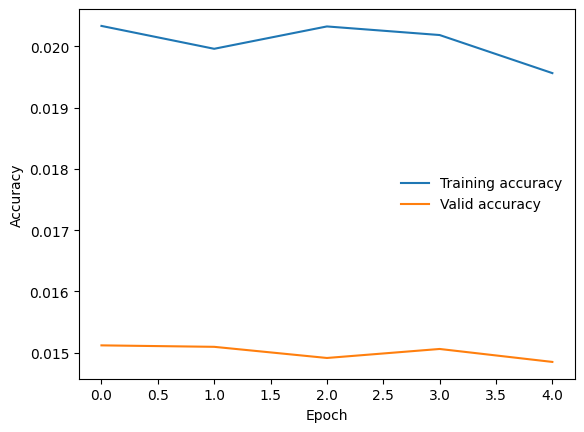

In [ ]:
class MLP_Batch(nn.Module):
    def __init__(self, input_dim, output_dim,use_batch_norm=False):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 400)
        self.hidden_fc1 = nn.Linear(400, 250)
        self.hidden_fc2 = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        self.use_batch_norm = use_batch_norm
        

        if use_batch_norm:
            self.batch_norm_input = nn.BatchNorm1d(400)
            self.batch_norm_fc1 = nn.BatchNorm1d(250)
            self.batch_norm_fc2 = nn.BatchNorm1d(100)


    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]
        ip_1=self.batch_norm_input(self.input_fc(x))
        h_1 = F.relu(ip_1)

        # h_1 = [batch size, 400]

        ip_2=self.batch_norm_fc1(self.hidden_fc1(h_1))
        h_2 = F.relu(ip_2)

        # h_2 = [batch size, 250]

        ip_3=self.batch_norm_fc2(self.hidden_fc2(h_2))
        h_3 = F.relu(ip_3)

        # h_3 = [batch size, 100]

        y_pred = self.output_fc(h_3)
        return y_pred, h_3

INPUT_DIM = 28 * 28
OUTPUT_DIM = 47
model_Batch = MLP_Batch(INPUT_DIM, OUTPUT_DIM,use_batch_norm=True)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_Batch = model_Batch.to(device)
criterion = criterion.to(device)

def train(model_Batch, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model_Batch.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model_Batch(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model_Batch, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model_Batch.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model_Batch(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

EPOCHS = 5

best_valid_loss = float('inf')

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model_Batch, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model_Batch, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model_Batch.state_dict(), 'tut3-model.pt')
     

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

# plot the loss graph
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot the accuracy graph
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Valid accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 51s
	Train Loss: 3.851 | Train Acc: 2.19%
	 Val. Loss: 3.849 |  Val. Acc: 2.43%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 50s
	Train Loss: 3.851 | Train Acc: 2.17%
	 Val. Loss: 3.849 |  Val. Acc: 2.43%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 51s
	Train Loss: 3.851 | Train Acc: 2.10%
	 Val. Loss: 3.849 |  Val. Acc: 2.43%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 51s
	Train Loss: 3.851 | Train Acc: 2.17%
	 Val. Loss: 3.849 |  Val. Acc: 2.43%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 51s
	Train Loss: 3.851 | Train Acc: 2.20%
	 Val. Loss: 3.849 |  Val. Acc: 2.43%


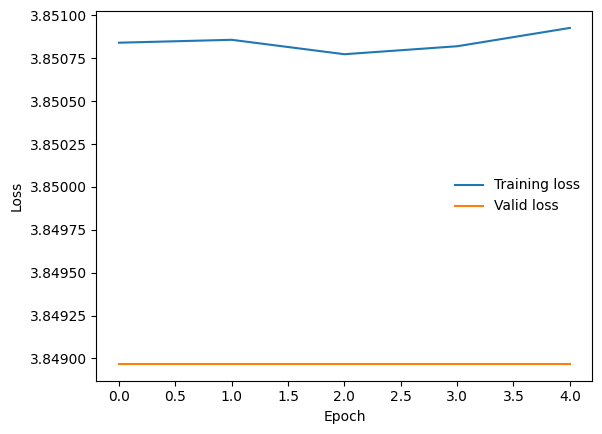

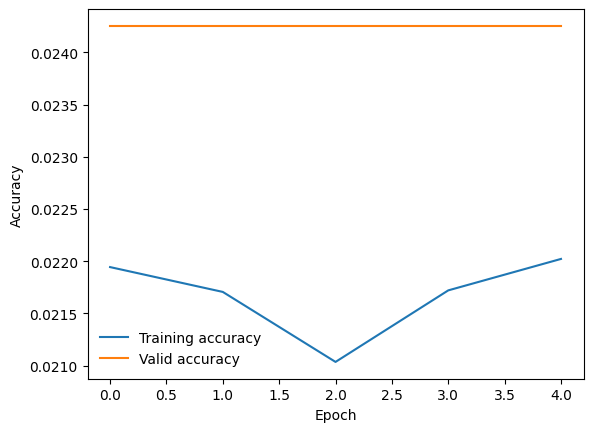

In [ ]:
class MLP_Dropout(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 400)
        self.hidden_fc1 = nn.Linear(400, 250)
        self.hidden_fc2 = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        ip_1=self.input_fc(x)
        h_1 = F.relu(ip_1)

        # h_1 = [batch size, 400]

        ip_2=self.hidden_fc1(h_1)
        h_2 = F.relu(ip_2)

        # h_2 = [batch size, 250]

        ip_3=self.hidden_fc2(h_2)
        h_3 = F.relu(ip_3)

        # h_3 = [batch size, 100]

        y_pred = self.output_fc(h_3)

        # y_pred = [batch size, output dim]

        return y_pred, h_3

INPUT_DIM = 28 * 28
OUTPUT_DIM = 47
model_dropout = MLP_Dropout(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dropout = model_dropout.to(device)
criterion = criterion.to(device)

def train(model_dropout, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model_dropout.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model_dropout(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model_dropout, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model_dropout.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model_dropout(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

EPOCHS = 5

best_valid_loss = float('inf')

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model_dropout, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model_dropout, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model_dropout.state_dict(), 'tut2-model.pt')
     

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

# plot the loss graph
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot the accuracy graph
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Valid accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
class MLP_test(nn.Module):
    def __init__(self, input_dim, output_dim, activation, use_batch_norm=False, use_dropout=False):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 400)
        self.hidden_fc1 = nn.Linear(400, 250)
        self.hidden_fc2 = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

        self.activation = activation
        self.activation_fn = {
            'leakyrelu':nn.LeakyReLU(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
        }[activation]

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        if use_batch_norm:
            self.batch_norm_input = nn.BatchNorm1d(400)
            self.batch_norm_fc1 = nn.BatchNorm1d(250)
            self.batch_norm_fc2 = nn.BatchNorm1d(100)

        if use_dropout:
            self.dropout = nn.Dropout(p=0.2)


    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]
        if self.use_batch_norm:
          ip_1=self.batch_norm_input(self.input_fc(x))
        else:
          ip_1=self.input_fc(x)

        # ip_1=self.input_fc(x)
        h_1 = self.activation_fn(ip_1)
        if self.use_dropout:
          h_1=self.dropout(h_1)

        # h_1 = [batch size, 400]
        if self.use_batch_norm:
          ip_2=self.batch_norm_fc1(self.hidden_fc1(h_1))
        else:
          ip_2=self.hidden_fc1(h_1)

        # ip_2=self.hidden_fc1(h_1)
        h_2 = self.activation_fn(ip_2)
        if self.use_dropout:
          h_2=self.dropout(h_2)

        # h_2 = [batch size, 250]
        if self.use_batch_norm:
          ip_3=self.batch_norm_fc2(self.hidden_fc2(h_2))
        else:
          ip_3=self.hidden_fc2(h_2)

        # ip_3=self.hidden_fc2(h_2)
        h_3 = self.activation_fn(ip_3)
        if self.use_dropout:
          h_3=self.dropout(h_3)

        # h_3 = [batch size, 100]

        y_pred = self.output_fc(h_3)

        # y_pred = [batch size, output dim]

        return y_pred, h_3



  0%|          | 0/15 [00:00<?, ?it/s]

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 51s
	Train Loss: 2.966 | Train Acc: 24.76%
	 Val. Loss: 1.884 |  Val. Acc: 54.66%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 52s
	Train Loss: 1.850 | Train Acc: 48.94%
	 Val. Loss: 1.068 |  Val. Acc: 70.58%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 51s
	Train Loss: 1.405 | Train Acc: 58.18%
	 Val. Loss: 0.787 |  Val. Acc: 76.25%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 52s
	Train Loss: 1.216 | Train Acc: 62.71%
	 Val. Loss: 0.670 |  Val. Acc: 79.12%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 52s
	Train Loss: 1.099 | Train Acc: 65.63%
	 Val. Loss: 0.609 |  Val. Acc: 80.25%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s
	Train Loss: 1.028 | Train Acc: 67.43%
	 Val. Loss: 0.565 |  Val. Acc: 81.55%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 52s
	Train Loss: 0.969 | Train Acc: 69.02%
	 Val. Loss: 0.547 |  Val. Acc: 81.71%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 52s
	Train Loss: 0.935 | Train Acc: 69.87%
	 Val. Loss: 0.516 |  Val. Acc: 82.73%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 52s
	Train Loss: 0.896 | Train Acc: 71.10%
	 Val. Loss: 0.498 |  Val. Acc: 83.04%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 52s
	Train Loss: 0.869 | Train Acc: 71.86%
	 Val. Loss: 0.484 |  Val. Acc: 83.57%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 52s
	Train Loss: 0.849 | Train Acc: 72.33%
	 Val. Loss: 0.478 |  Val. Acc: 83.82%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 52s
	Train Loss: 0.830 | Train Acc: 72.98%
	 Val. Loss: 0.471 |  Val. Acc: 83.83%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 52s
	Train Loss: 0.815 | Train Acc: 73.30%
	 Val. Loss: 0.464 |  Val. Acc: 84.04%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 52s
	Train Loss: 0.798 | Train Acc: 73.99%
	 Val. Loss: 0.450 |  Val. Acc: 84.46%


Training:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 52s
	Train Loss: 0.784 | Train Acc: 74.33%
	 Val. Loss: 0.445 |  Val. Acc: 84.61%


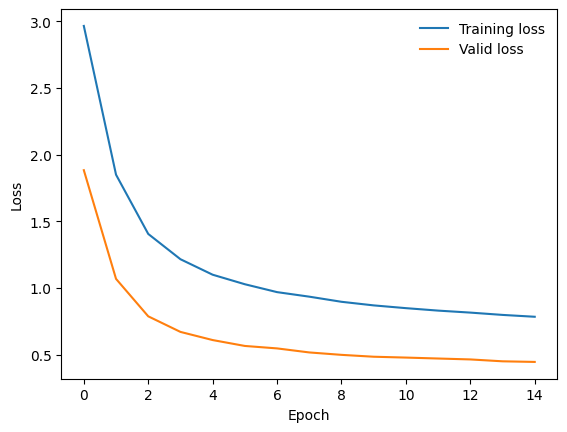

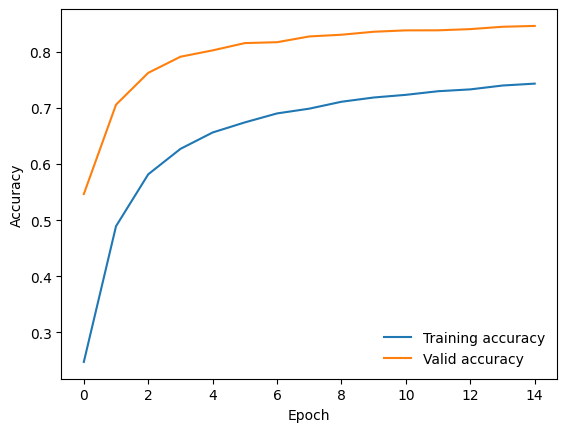

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Test Loss: 0.465 | Test Acc: 84.18%


In [ ]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 47
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = criterion.to(device)

EPOCHS = 15
# train and evaluate for base model
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
best_accuracy = 0.0
model_test = MLP_test(INPUT_DIM, OUTPUT_DIM, activation='relu', use_batch_norm=True, use_dropout=True)
optimizer = optim.Adam(model_test.parameters())
model_test = model_test.to(device)
for epoch in trange(EPOCHS):
  start_time = time.monotonic()

  train_loss, train_acc = train(model_test, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model_test, valid_iterator, criterion, device)

  if valid_acc > best_accuracy:
    best_accuracy = valid_acc
    torch.save(model_test.state_dict(), 'tut40-model.pt')

  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  valid_losses.append(valid_loss)
  valid_accuracies.append(valid_acc)

# plot the loss graph
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Valid loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# plot the accuracy graph
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(valid_accuracies, label='Valid accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

model_test.load_state_dict(torch.load('tut40-model.pt'))

test_loss, test_acc = evaluate(model_test, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Examining the Model

Checking what examples the model gets wrong to ensure that theyre reasonable

The function below will return the models predictions over a given dataset.It will return the inputs (image) the outputs (model predictions) and the ground truth labels

In [ ]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model_test, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(47, 47))
    ax = fig.add_subplot(2, 2, 2)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(47))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

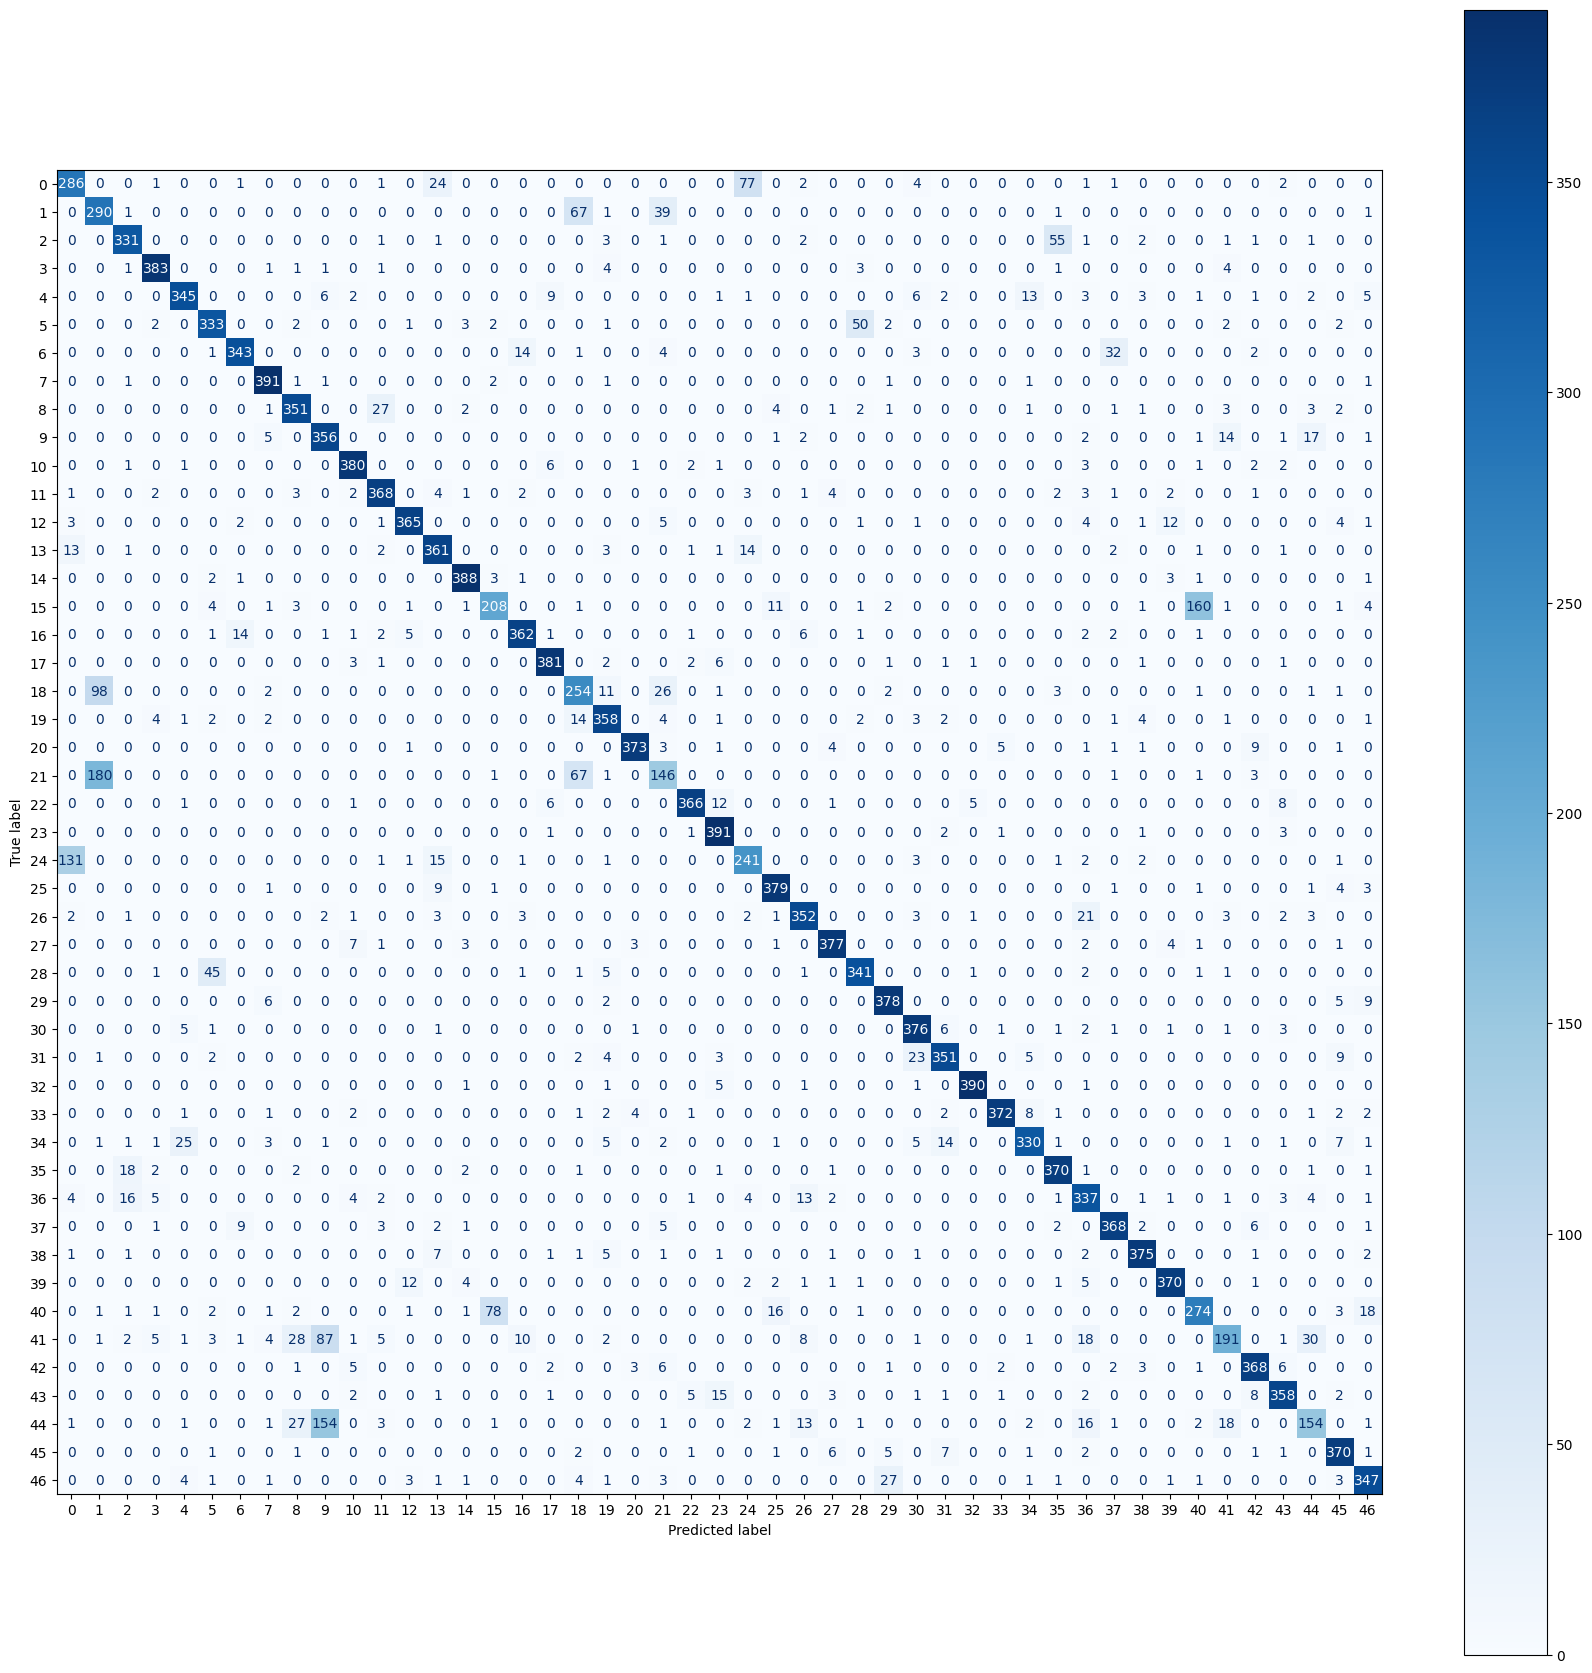

In [ ]:
plot_confusion_matrix(labels, pred_labels)

## Visualising some of the most correctlly predicted images

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:


correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if correct:
    correct_examples.append((image, label, prob))

correct_examples.sort(reverse=True, 
                        key=lambda x: torch.max(x[2], dim=0).values)


In [ ]:
def plot_most_correct(correct, n_images):

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(20, 10))
  for i in range(rows*cols):
      ax = fig.add_subplot(rows, cols, i+1)
      image, true_label, probs = correct[i]
      true_prob = probs[true_label]
      correct_prob, correct_label = torch.max(probs, dim=0)
      ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
      ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {correct_label} ({correct_prob:.3f})')
      ax.axis('off')
  fig.subplots_adjust(hspace=0.5)

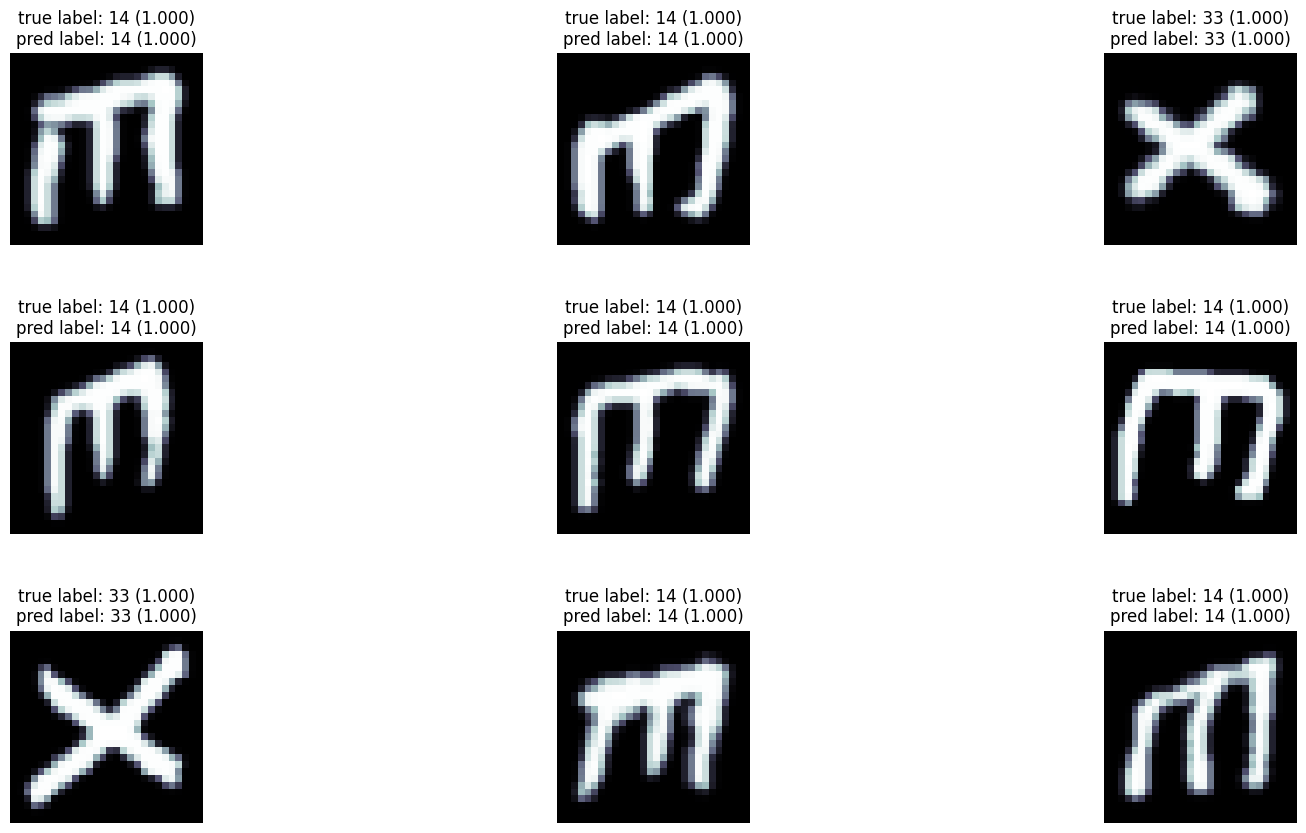

In [ ]:
N_IMAGES = 12

plot_most_correct(correct_examples, N_IMAGES)

In [ ]:
from sklearn.metrics import classification_report
# convert tensors to numpy arrays
true_labels = labels.numpy()
predicted_labels = pred_labels.numpy()

# calculate classification report
report = classification_report(labels.cpu(), pred_labels.cpu())

# print report
print(report)

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       400
           1       0.51      0.72      0.60       400
           2       0.88      0.83      0.85       400
           3       0.94      0.96      0.95       400
           4       0.90      0.86      0.88       400
           5       0.84      0.83      0.83       400
           6       0.92      0.86      0.89       400
           7       0.93      0.98      0.95       400
           8       0.83      0.88      0.85       400
           9       0.58      0.89      0.71       400
          10       0.92      0.95      0.94       400
          11       0.88      0.92      0.90       400
          12       0.94      0.91      0.92       400
          13       0.84      0.90      0.87       400
          14       0.95      0.97      0.96       400
          15       0.70      0.52      0.60       400
          16       0.92      0.91      0.91       400
          17       0.93    

In [ ]:
# Split the training dataset into training and validation sets based on the specified validation ratio
VALID_RATIO = 0.9 # Change the size of the validation set333333333333

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

# Print the number of examples in each dataset after the split
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

# Apply the test transformations to the validation set
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms


# Define the batch size and create data iterators for the training, validation, and testing sets
BATCH_SIZE = 1000 

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

Number of training examples: 71064
Number of validation examples: 7896
Number of testing examples: 18800


In [ ]:

# Check if a CUDA-capable GPU is available and set the device to use CUDA if it is, otherwise set the device to use the CPU.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Defining the CNN
## Defining Forward Feed Function

In [ ]:
class CNNet(nn.Module):
  # Constructor for the CNNet class
  # Super initializes the nn.module base class
  def __init__(self): 
    super(CNNet, self).__init__()
    # First convolutional layer ('conv1') - 1-channel input and 20-channel output. Kernel size = 5
    self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
    # Second convolutional layer ('conv2') - 20-channel input(conv1 output) and 20-channels output. Kernel size = 5
    self.conv2 = nn.Conv2d(20, 20, kernel_size=5)
    # Batch normalization after each convolutional layer
    self.bn1 = nn.BatchNorm2d(20)
    self.bn2 = nn.BatchNorm2d(20)
    # First fully connected layer ('fc1') - 20*4*4 input features and 500 output features
    self.fc1 = nn.Linear(20*4*4, 500)
    # Second fully connected layer ('fc2') - 50 input features('fc1' output) and 47 output features 
    self.fc2 = nn.Linear(500, 47)
    # Adaptive learning rate
    self.scheduler = None

  # Set the scheduler for adaptive learning rate
  def set_scheduler(self, scheduler):
    self.scheduler = scheduler

  # Forward feed function

  def forward(self, x, target=None):
    # Convolutional Layer/Normalization/Pooling Layer/Activation
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.max_pool2d(x, 2)
    # Convolutional Layer/Normalization/Pooling Layer/Activation
    x = F.relu(self.bn2(self.conv2(x)))
    x = F.max_pool2d(x, 2)
    # Flattening the output from the Convolutional layers to 1D vectors
    x = x.view(-1, 320)
    # Applying the first fully connected layer to x applying and activation function
    x = F.relu(self.fc1(x))
    # Adding L1 regularization to the loss calculation
    l1_reg = torch.tensor(0.0)
    for param in self.parameters():
        l1_reg += torch.norm(param, p=1)
    if target is not None:
        loss = F.cross_entropy(x, target) + 0.001 * l1_reg
    # Applying the second fully connected layer to the output of 'fc1'
    x = self.fc2(x)
    # Applying a softmax function to the output of 'fc2' to get the probability distribution 
    return F.log_softmax(x, dim=1)





## Implementing a learning rate scheduler 

In [ ]:


# Create the model
model = CNNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Create the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Set the scheduler for the model
model.set_scheduler(scheduler)


## Defining the accuracy function

In [ ]:
# Accuracy Function

def accuracy(output, target):
    # get the index of the max log-probability
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(target)
    return acc


## Defining the train function

In [ ]:

def train(epoch):
    # Set the model to train mode
    model.train()

    # Initialize variables to store total loss and accuracy 
    total_loss = 0
    total_acc = 0

    # Initialize tqdm to track progress
    
    pbar = tqdm(enumerate(train_iterator), total=len(train_iterator))


    # Looping over the batched of data from the train_loader
    for batch_idx, (data, target) in pbar: #train_loader

        # Moving the data + target tensors to GPU if 'cuda' flag is True
        if args['cuda']:
            data, target = data.cuda(), target.cuda()

        # Converting data and target tensors to PyTorch Variables
        data, target = Variable(data), Variable(target)

        # Clearing the gradients of all optimized tensors
        optimizer.zero_grad()

        # Computing the forward pass of the NN on current batch of data
        output = model(data, target)

        # Calculating the loss/Computing the negative log likelihood between the predicted output and target 
        loss = F.nll_loss(output, target)

        # Compute the gradients of all the trainable parameters in the model with respect to loss
        loss.backward()

        # One step update of the model parameters with the gradients from the previous step using optimizer
        optimizer.step()

        # Compute the accuracy
        acc = accuracy(output, target)

        # Add current batch's loss and accuracy to the total
        total_loss += loss.item()
        total_acc += acc

        # Update tqdm progress bar with current batch's loss and accuracy
        pbar.set_description('Train Epoch: {} Loss: {:.6f} Accuracy: {:.2f}%'.format(
            epoch, loss.item(), 100. * acc))

    # Close the tqdm progress bar
    pbar.close()

    # Compute the average loss and accuracy across all batches
    avg_loss = total_loss / len(train_iterator)
    avg_acc = total_acc / len(train_iterator)

    # Return the average loss and accuracy for the epoch
    return avg_loss, avg_acc 



## Definining the Evaluation function for the validation set

In [ ]:
# Testing/Evaluating the CNNet on the test_loader data splitn

def evaluating():
    # Setting the model to evaluation mode - No weight update + Dropout and batch normalization disabled
    model.eval()

    # Initialising test loss to zero
    valid_loss = 0

    # Initialising number of correctly classified examples to zero
    correct = 0

    # Iterating over the test loader
    with torch.no_grad():
        for data, target in valid_iterator:
            # Moving the data + target tensors to GPU if 'cuda'flag = True
            if args['cuda']:
                data, target = data.cuda(), target.cuda()

            # Converting data and target tensors to PytTorch Variables
            data, target = Variable(data), Variable(target)

            # Passing the input data through the model to generate predicted labels
            output = model(data)

            # Calculating the loss/Computing the negative log likelihood between the predicted output and target 
            valid_loss += F.nll_loss(output, target, reduction='sum').item()

            # Extracting the predicted class labels by taking the argmax over the output probabilities for each example
            pred = output.data.max(1, keepdim=True)[1]

            # Comparing the predicted labels to the ground truth label, and adding the number of correct predictions to the running total
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    # Computing the average test loss over all examples in the test set
    valid_loss /= len(valid_iterator.dataset)

    # Print the accuracy for the validation set
    print('\nValid set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(valid_iterator.dataset),
        100. * correct / len(valid_iterator.dataset)))


## Creating an instance of the CNN
- Printing/Plotting the: 
* Train Acc
* Train Loss
* Val Acc 


  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6154/7896 (78%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6556/7896 (83%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6699/7896 (85%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6709/7896 (85%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6710/7896 (85%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6793/7896 (86%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6789/7896 (86%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6782/7896 (86%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6894/7896 (87%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6821/7896 (86%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6914/7896 (88%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6868/7896 (87%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6863/7896 (87%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6874/7896 (87%)



  0%|          | 0/72 [00:00<?, ?it/s]


Valid set: Accuracy: 6879/7896 (87%)



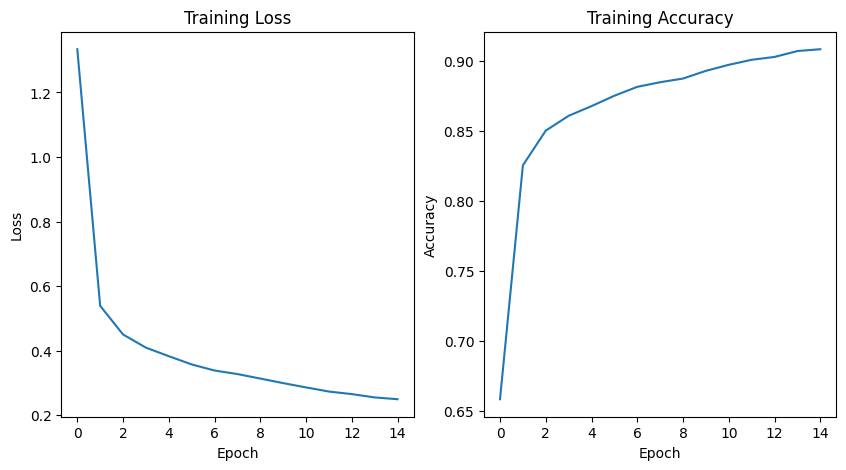

In [ ]:
model = CNNet()
if args['cuda']:
  model.cuda()

optimizer = optim.Adam(model.parameters())


# Initialize lists to store loss and accuracy at the end of each epoch
train_losses_end = []
train_accs_end = []

# Loop over the epochs
for epoch in range(1, args['epochs'] + 1):
    # Train the model for one epoch and get the train_losses and train_accs for the epoch
    train_losses, train_accs = train(epoch)
    evaluating()
    
    # Accumulate the loss and accuracy values at the end of the epoch
    train_losses_end.append(train_losses)
    train_accs_end.append(train_accs)

# Plot the loss and accuracy at the end of all epochs
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses_end)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs_end)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Defining test function

In [ ]:
def testing():
    # Setting the model to evaluation mode - No weight update + Dropout and batch normalization disabled
    model.eval()

    # Initialising test loss to zero
    test_loss = 0

    # Initialising number of correctly classified examples to zero
    correct = 0

    # Iterating over the test loader
    with torch.no_grad():
        for data, target in test_iterator:
            # Moving the data + target tensors to GPU if 'cuda'flag = True
            if args['cuda']:
                data, target = data.cuda(), target.cuda()

            # Converting data and target tensors to PytTorch Variables
            data, target = Variable(data), Variable(target)

            # Passing the input data through the model to generate predicted labels
            output = model(data)

            # Calculating the loss/Computing the negative log likelihood between the predicted output and target 
            test_loss += F.nll_loss(output, target, reduction='sum').item()

            # Extracting the predicted class labels by taking the argmax over the output probabilities for each example
            pred = output.data.max(1, keepdim=True)[1]

            # Comparing the predicted labels to the ground truth label, and adding the number of correct predictions to the running total
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    # Computing the average test loss over all examples in the test set
    test_loss /= len(valid_iterator.dataset)

    print('\nValid set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_iterator.dataset),
        100. * correct / len(test_iterator.dataset)))

## Evaluating the model on the testing dataset

In [ ]:
testing()




Valid set: Average loss: 0.9407, Accuracy: 16279/18800 (87%)



## Examining the Predictions

## Defining a function to retrieve the predictions

In [ ]:
def get_predictions(model, iterator, device):
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x) # Remove the second value from the output
            y_prob = F.log_softmax(y_pred, dim=1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

# create a device object for the CPU
device = torch.device('cpu')

images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

## Defining a function for plotting the confusion matrix

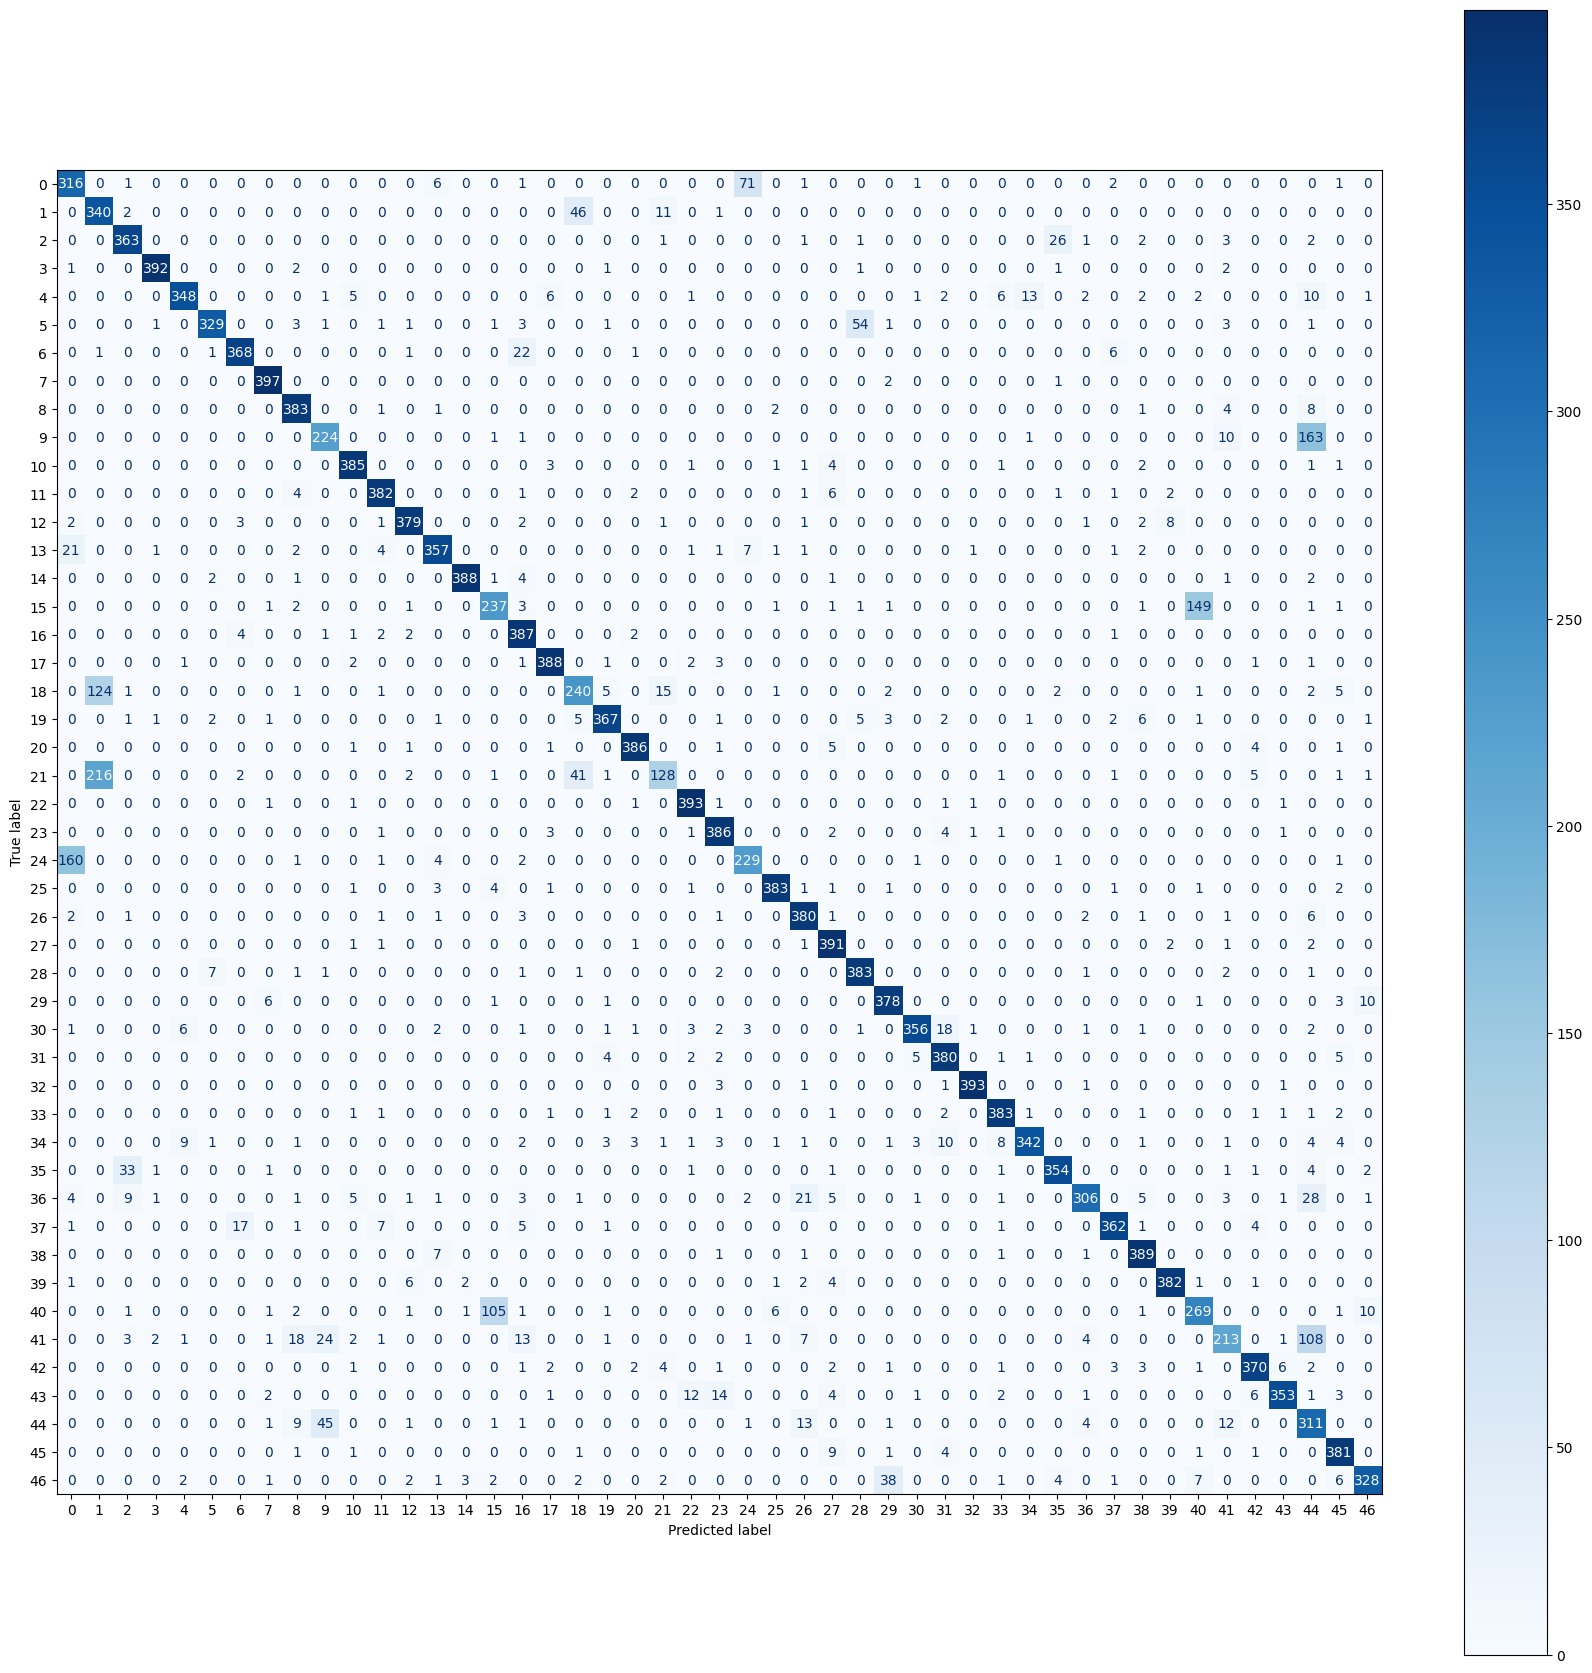

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(47, 47))
    ax = fig.add_subplot(2, 2, 2)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(47))
    cm.plot(values_format='d', cmap='Blues', ax=ax)


plot_confusion_matrix(labels, pred_labels)

## Plotting 6 of the most correctly predicted images

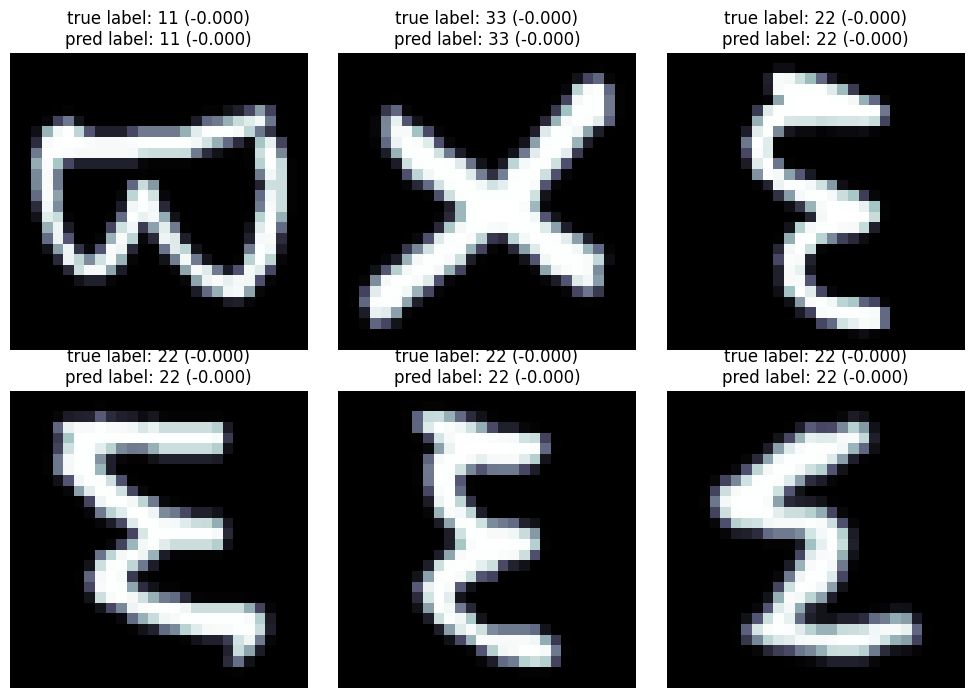

In [ ]:
corrects = torch.eq(labels, pred_labels)

correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

def plot_most_correct(correct, n_images):
    rows = 2
    cols = 3
    fig = plt.figure(figsize=(10, 7))
    for i in range(n_images):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = correct[i]
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {correct_label} ({correct_prob:.3f})')
        ax.axis('off')
    fig.tight_layout()

N_IMAGES = 6

plot_most_correct(correct_examples, N_IMAGES)

In [ ]:
def plot_most_correct(correct, n_images):

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(20, 10))
  for i in range(rows*cols):
      ax = fig.add_subplot(rows, cols, i+1)
      image, true_label, probs = correct[i]
      true_prob = probs[true_label]
      correct_prob, correct_label = torch.max(probs, dim=0)
      ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
      ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {correct_label} ({correct_prob:.3f})')
      ax.axis('off')
  fig.subplots_adjust(hspace=0.5)

## Reporting the F1, Precision score and Recall

In [ ]:
from sklearn.metrics import classification_report

# convert tensors to numpy arrays
true_labels = labels.numpy()
predicted_labels = pred_labels.numpy()

# calculate classification report
report = classification_report(labels.cpu(), pred_labels.cpu())

# print report
print(report)

              precision    recall  f1-score   support

           0       0.62      0.79      0.70       400
           1       0.50      0.85      0.63       400
           2       0.87      0.91      0.89       400
           3       0.98      0.98      0.98       400
           4       0.95      0.87      0.91       400
           5       0.96      0.82      0.89       400
           6       0.93      0.92      0.93       400
           7       0.96      0.99      0.98       400
           8       0.88      0.96      0.92       400
           9       0.75      0.56      0.64       400
          10       0.95      0.96      0.95       400
          11       0.94      0.95      0.95       400
          12       0.95      0.95      0.95       400
          13       0.93      0.89      0.91       400
          14       0.98      0.97      0.98       400
          15       0.67      0.59      0.63       400
          16       0.84      0.97      0.90       400
          17       0.96    